# Opening images

This notebook will show how to access metadata and pixel values of several images with QuBaLab.

QuBaLab uses the `ImageServer` class to open an image and get its metadata and pixel values. `ImageServer` is an abstract class, so it cannot be directly used. Instead, you have to choose an implementation based on the type of image you want to open:

* If you need to open an RGB pyramidal image, you can use the `OpenSlideServer`. This class internally uses [OpenSlide](https://openslide.org/): it can read all resolutions of a large pyramidal image but is only suitable for RGB images.
* If you need to open any kind of microscopy image, you can use the `AICSImageIoServer`. This class internally uses [AICSImageIO](https://github.com/AllenCellModeling/aicsimageio) which is suited for a lot of formats. However, this library does not properly support pyramids, so you might only get the full resolution image when opening a pyramidal image.

This notebook will show how to use the two image servers with two different images. You'll see that except for the image server creation, all functions are the same.

A third `ImageServer`, `IccProfileServer`, is also presented in this notebook. It's a special kind of `ImageServer` that wraps another `ImageServer` and apply an ICC Profile to the pixels, if possible. You can find more information on ICC profile on [this link](http://www.andrewjanowczyk.com/application-of-icc-profiles-to-digital-pathology-images/).

Finally, this notebook will show how to open an `ImageServer` with [napari](https://napari.org/).

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def displayImage(image, title=None):
    """
    A utility function to display a NumPy array returned by an ImageServer.
    """
    
    # ImageServers return arrays with dimensions (number_of_channels, tile_height, tile_width),
    # but matplotlib wants the channels to appear last, so this axis need to be moved
    image = np.moveaxis(image, [0], [2])

    # ImageServers may return any number of channels, while matplotlib only accepts at most 3 channels,
    # so only the first channel is kept if there are more than 3 channels
    if image.shape[2] > 3:
        image = image[..., 0]

    # If pixel values are float numbers, they can be greater than 0, while matplotlib only accepts
    # values between 0 and 1, so the array is normalized between 0 and 1
    if image.dtype != "uint8":
        image /= image.max()

    if title is not None:
        plt.title(title)

    plt.imshow(image)
    plt.show()

## OpenSlideServer

We will use the **CMU-1.svs** image (CC0 1.0 license).

In [3]:
# Download image

import urllib.request

cmu_path, _ = urllib.request.urlretrieve("https://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1.svs")
print(f'CMU-1.svs saved to {cmu_path}')

CMU-1.svs saved to /var/folders/zt/w6w5hpx561d_n1n6613yy7dh0000gt/T/tmprvaba1nl


In [4]:
from qubalab.images.openslide_server import OpenSlideServer


# Create the ImageServer. This will read the image metadata but not the pixel values yet
openslide_server = OpenSlideServer(cmu_path)

/Users/lleplat/QuPath/Projects/qubalab/qubalab/qubalab/images/openslide_server.py:9: UserWarning: Unable to import OpenSlide, will try TiffSlide instead
  warnings.warn(f'Unable to import OpenSlide, will try TiffSlide instead')
/Users/lleplat/QuPath/Projects/qubalab/qubalab/qubalab/images/openslide_server.py:39: UserWarning: compatibility: aliasing tiffslide.TiffSlide to 'OpenSlide'
  self._reader = openslide.OpenSlide(path)


### Image metadata

Image metadata is access with the `ImageServer.metadata` property.

In [5]:
# Access image metadata

cmu_metadata = openslide_server.metadata

print(f'Image path: {cmu_metadata.path}')
print(f'Image name: {cmu_metadata.name}')
print()

print('Levels:')
for level, shape in enumerate(cmu_metadata.shapes):
    print(f'Shape of level {level}: {shape}')
print()

print('Pixel calibration:')
print(f'Pixel length on x-axis: {cmu_metadata.pixel_calibration.length_x}')
print(f'Pixel length on y-axis: {cmu_metadata.pixel_calibration.length_y}')
print()

print(f'Pixel type: {cmu_metadata.dtype}')
print()

print(f'Downsamples: {cmu_metadata.downsamples}')
print()

print('Channels:')
for channel in cmu_metadata.channels:
    print(channel)

Image path: /var/folders/zt/w6w5hpx561d_n1n6613yy7dh0000gt/T/tmprvaba1nl
Image name: tmprvaba1nl

Levels:
Shape of level 0: ImageShape(x=46000, y=32914, t=1, c=3, z=1)
Shape of level 1: ImageShape(x=11500, y=8228, t=1, c=3, z=1)
Shape of level 2: ImageShape(x=2875, y=2057, t=1, c=3, z=1)

Pixel calibration:
Pixel length on x-axis: PixelLength(length=0.499, unit='micrometer')
Pixel length on y-axis: PixelLength(length=0.499, unit='micrometer')

Pixel type: <class 'numpy.uint8'>

Downsamples: (1, 4, 16)

Channels:
ImageChannel(name='Red', color=(1, 0, 0))
ImageChannel(name='Green', color=(0, 1, 0))
ImageChannel(name='Green', color=(0, 0, 1))


### Pixel values

Pixel values can be retrieved in two different ways:

* If the image is small enough to fit in memory, or if only one tile of the image should be read, then the `ImageServer.read_region()` function can be used.
* Otherwise, the `ImageServer.level_to_dask()` or `ImageServer.to_dask()` functions can be used. They will return a [Dask array](https://docs.dask.org/en/latest/array.html) which gives as a NumPy-like way to access the pixels without fitting all pixel values into memory. Indeed, as long as `compute()` is not called on the Dask array, the pixel values won't be read.

#### read_region()

`ImageServer.readRegion()` returns a NumPy array of a tile of the image with dimensions `(number_of_channels, tile_height, tile_width)`.

Image shape: (3, 2057, 2875)


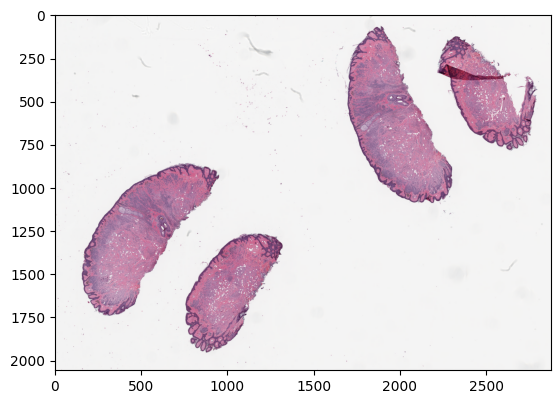

In [6]:
# Read and show lowest resolution image with read_region

highest_downsample = openslide_server.metadata.downsamples[-1]
lowest_resolution = openslide_server.read_region(highest_downsample)

print(f'Image shape: {lowest_resolution.shape}')

displayImage(lowest_resolution)

Tile shape: (3, 1000, 2000)


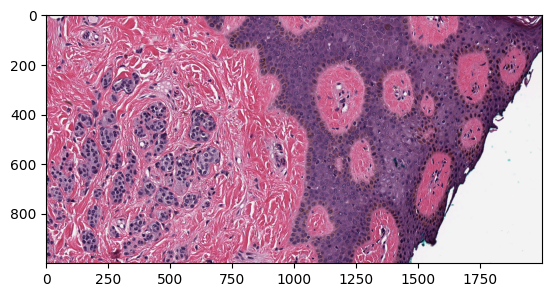

In [7]:
# Read and show tile of full resolution image with read_region

# Read a 2000x1000 pixels tile whose top left pixel is located at x=13000 and y=15000 on the full resolution image
downsample = 1
x = 13000
y = 15000
width = 2000
height = 1000
tile = openslide_server.read_region(downsample, x=x, y=y, width=width, height=height)

print(f'Tile shape: {tile.shape}')

displayImage(tile)

#### level_to_dask()

`ImageServer.level_to_dask()` returns a Dask array representing a single resolution of the image.

Pixels of the returned array can be accessed with the following order: (t, c, z, y, x). There may be less dimensions for simple images: for example, an image with a single timepoint and a single z-slice will return an array of dimensions (c, y, x) (which is the case here). However, there will always be dimensions x and y, even if they have a size of 1.

Image shape: (3, 2057, 2875)


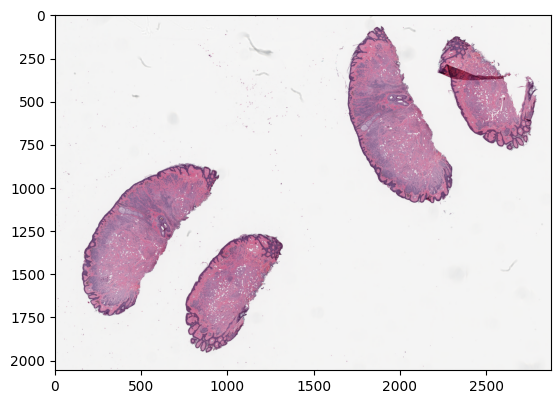

In [8]:
# Read and show lowest resolution image with level_to_dask

last_level = openslide_server.metadata.n_resolutions - 1
lowest_resolution = openslide_server.level_to_dask(last_level)

# Pixel values are not read yet, but you can get the shape of the image
print(f'Image shape: {lowest_resolution.shape}')

# Compute array. This will read the pixel values
lowest_resolution = lowest_resolution.compute()

displayImage(lowest_resolution)

Full resolution image shape: (3, 32914, 46000)
Tile shape: (3, 1000, 2000)


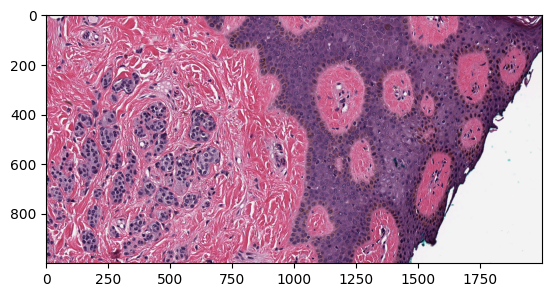

In [9]:
# Read and show tile of full resolution image with level_to_dask

first_level = 0
highest_resolution = openslide_server.level_to_dask(first_level)

print(f'Full resolution image shape: {highest_resolution.shape}')

# Only read a 2000x1000 pixels tile whose top left pixel is located at x=13000 and y=15000 on the full resolution image
x = 13000
y = 15000
width = 2000
height = 1000
tile = highest_resolution[:, y:y+height, x:x+width]

print(f'Tile shape: {tile.shape}')

# Compute array. This will only read the pixel values of the tile, not the entire image
tile = tile.compute()

displayImage(tile)

#### to_dask()

`ImageServer.to_dask()` returns a Dask array representing the image at any arbitrary downsample (even a downsample not stored in the image).

Pixels of the returned array can be accessed with the following order: (t, c, z, y, x). There may be less dimensions for simple images: for example, an image with a single timepoint and a single z-slice will return an array of dimensions (c, y, x) (which is the case here). However, there will always be dimensions x and y, even if they have a size of 1.

**Important!**
> It turns out that requesting at an arbitrary downsample level is very slow - it seems that all pixels are requested upon first compute (even for a small region), and then resized.

/Users/lleplat/QuPath/Projects/qubalab/qubalab/qubalab/images/image_server.py:198: UserWarning: Warning - calling affine_transform on a large dask array can be *very* slow
  warnings.warn('Warning - calling affine_transform on a large dask array can be *very* slow')


Image shape at downsample 1.5: (3, 21943, 30667)
Tile shape: (3, 1000, 2000)


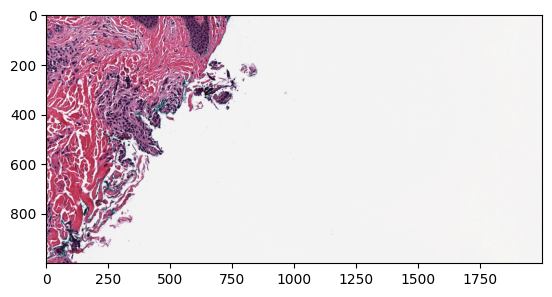

In [10]:
# Read and show a tile of the image at an arbitray downsample

downsample = 1.5
image = openslide_server.to_dask(downsample)

# Pixel values are not read yet, but you can get the shape of the image
print(f'Image shape at downsample {downsample}: {image.shape}')

# Only read a 2000x1000 pixels tile whose top left pixel is located at x=13000 and y=15000 on the downsampled image
x = 13000
y = 15000
width = 2000
height = 1000
tile = image[:, y:y+height, x:x+width]

print(f'Tile shape: {tile.shape}')

# Compute array. This will only read the pixel values of the tile, not the entire image
tile = tile.compute()

displayImage(tile)

## AICSImageIoServer

We will use the **LuCa-7color_[13860,52919]_1x1component_data.tif** image (CC-BY 4.0 license).

In [11]:
# Download image

import urllib.request

luca_path, _ = urllib.request.urlretrieve("https://downloads.openmicroscopy.org/images/Vectra-QPTIFF/perkinelmer/PKI_fields/LuCa-7color_%5b13860,52919%5d_1x1component_data.tif")
print(f'LuCa-7color_[13860,52919]_1x1component_data.tif saved to {luca_path}')

LuCa-7color_[13860,52919]_1x1component_data.tif saved to /var/folders/zt/w6w5hpx561d_n1n6613yy7dh0000gt/T/tmpkrbn7a64


In [12]:
from qubalab.images.aicsimageio_server import AICSImageIoServer


# Create the ImageServer. This will read the image metadata but not the pixel values yet
aicsimageio_server = AICSImageIoServer(luca_path)

/Users/lleplat/Library/Caches/pypoetry/virtualenvs/qubalab-qsobDmiH-py3.12/lib/python3.12/site-packages/pydantic/_migration.py:283: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')


### Image metadata

In [13]:
# Access image metadata

luca_metadata = aicsimageio_server.metadata

print(f'Image path: {luca_metadata.path}')
print(f'Image name: {luca_metadata.name}')
print()

print('Levels:')
for level, shape in enumerate(luca_metadata.shapes):
    print(f'Shape of level {level}: {shape}')
print()

# The LuCa image has a pixel unit in micrometers, but here it's showing the pixel unit:
# it's because The AICSImage library does not currently handle unit attachment
print('Pixel calibration:')
print(f'Pixel length on x-axis: {luca_metadata.pixel_calibration.length_x}')
print(f'Pixel length on y-axis: {luca_metadata.pixel_calibration.length_y}')
print()

print(f'Pixel type: {luca_metadata.dtype}')
print()

print(f'Downsamples: {luca_metadata.downsamples}')
print()

print('Channels:')
for channel in luca_metadata.channels:
    print(channel)

Image path: /var/folders/zt/w6w5hpx561d_n1n6613yy7dh0000gt/T/tmpkrbn7a64
Image name: tmpkrbn7a64

Levels:
Shape of level 0: ImageShape(x=1868, y=1400, t=1, c=8, z=1)

Pixel calibration:
Pixel length on x-axis: PixelLength(length=0.4979944789079005, unit='pixels')
Pixel length on y-axis: PixelLength(length=0.4979944789079005, unit='pixels')

Pixel type: float32

Downsamples: (1,)

Channels:
ImageChannel(name='Channel 1', color=(0, 1, 1))
ImageChannel(name='Channel 2', color=(1, 1, 0))
ImageChannel(name='Channel 3', color=(1, 0, 1))
ImageChannel(name='Channel 4', color=(1, 0, 0))
ImageChannel(name='Channel 5', color=(0, 1, 0))
ImageChannel(name='Channel 6', color=(0, 0, 1))
ImageChannel(name='Channel 7', color=(0, 1, 1))
ImageChannel(name='Channel 8', color=(1, 1, 0))


### Pixel values

#### read_region()

Image shape: (8, 1400, 1868)


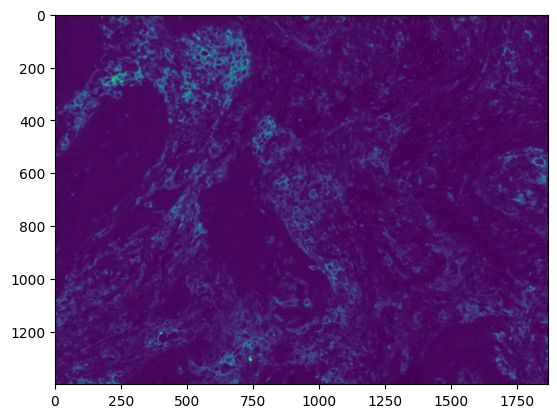

In [14]:
# Read and show image with read_region

downsample = 1
image = aicsimageio_server.read_region(downsample)

print(f'Image shape: {image.shape}')

displayImage(image)  # Only display first channel

Tile shape: (8, 100, 200)


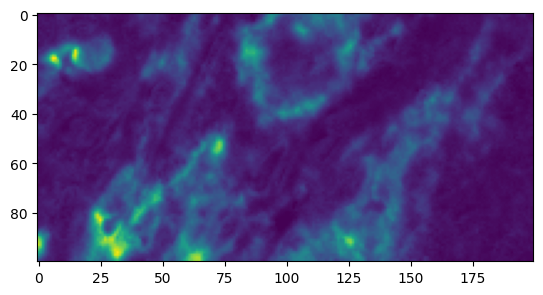

In [15]:
# Read and show tile of the image with read_region

# Read a 200x100 pixels tile whose top left pixel is located at x=500 and y=500 on the image
downsample = 1
x = 500
y = 500
width = 200
height = 100
tile = aicsimageio_server.read_region(downsample, x=x, y=y, width=width, height=height)

print(f'Tile shape: {tile.shape}')

displayImage(tile)

#### level_to_dask()

Image shape: (8, 1400, 1868)


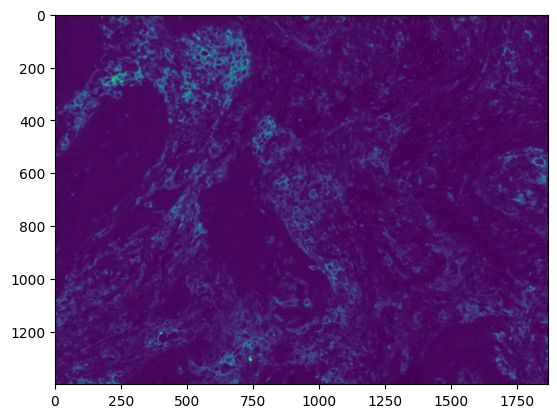

In [16]:
# Read and show image with level_to_dask

level = 0
image = aicsimageio_server.level_to_dask(level)

# Pixel values are not read yet, but you can get the shape of the image
print(f'Image shape: {image.shape}')

# Compute array. This will read the pixel values
image = image.compute()

displayImage(image)

Image shape: (8, 1400, 1868)
Tile shape: (8, 100, 200)


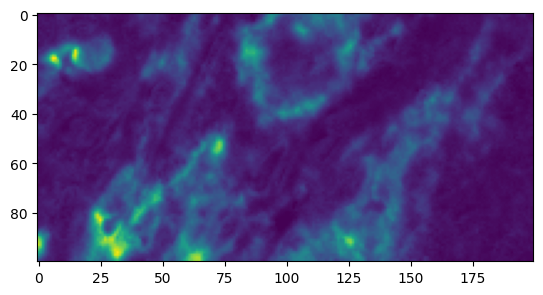

In [17]:
# Read and show tile of the image with level_to_dask

level = 0
image = aicsimageio_server.level_to_dask(level)

print(f'Image shape: {image.shape}')

# Only read a 200x100 pixels tile whose top left pixel is located at x=500 and y=500 on the image
x = 500
y = 500
width = 200
height = 100
tile = image[:, y:y+height, x:x+width]

print(f'Tile shape: {tile.shape}')

# Compute array. This will only read the pixel values of the tile, not the entire image
tile = tile.compute()

displayImage(tile)

#### to_dask()

/Users/lleplat/QuPath/Projects/qubalab/qubalab/qubalab/images/image_server.py:198: UserWarning: Warning - calling affine_transform on a large dask array can be *very* slow
  warnings.warn('Warning - calling affine_transform on a large dask array can be *very* slow')


Image shape at downsample 1.5: (8, 933, 1245)
Tile shape: (8, 100, 200)


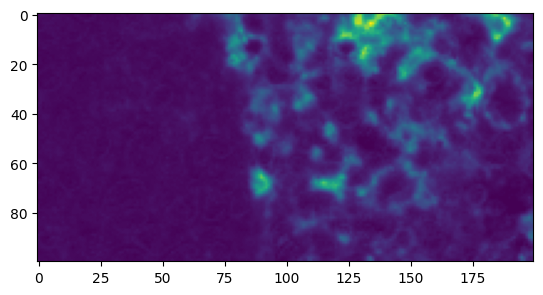

In [18]:
# Read and show a tile of the image at an arbitray downsample

downsample = 1.5
image = aicsimageio_server.to_dask(downsample)

# Pixel values are not read yet, but you can get the shape of the image
print(f'Image shape at downsample {downsample}: {image.shape}')

# Only read a 200x100 pixels tile whose top left pixel is located at x=200 and y=200 on the downsampled image
x = 200
y = 200
width = 200
height = 100
tile = image[:, y:y+height, x:x+width]

print(f'Tile shape: {tile.shape}')

# Compute array. This will only read the pixel values of the tile, not the entire image
tile = tile.compute()

displayImage(tile)

## IccProfileServer

We will use the `OpenSlideServer` created above, because it represents the **CMU-1.svs** image, and SVS images usually embed an ICC profile. However, any `ImageServer` can be used.

In [19]:
from qubalab.images.icc_profile_server import IccProfileServer


icc_profile_server = IccProfileServer(openslide_server)

ICC profiles change the pixel values. To see that, we can display the lowest resolution image with and without the ICC profile.

Mean value with ICC profile: 226.1774387633602
Mean value without ICC profile: 225.44691836288953


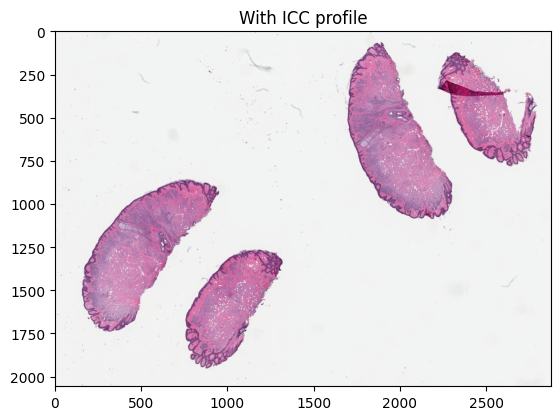

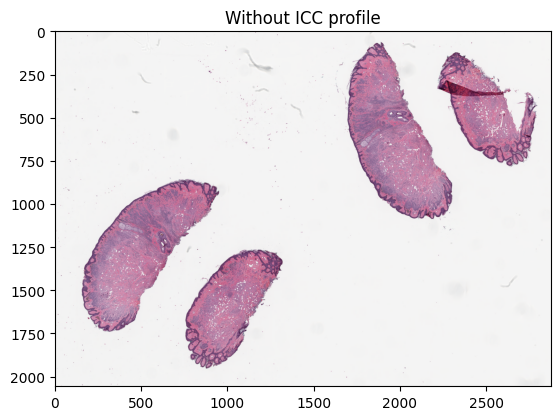

In [20]:
# Read and show lowest resolution image with and without the ICC profile

highest_downsample = icc_profile_server.metadata.downsamples[-1]

with_icc = icc_profile_server.read_region(highest_downsample)
without_icc = openslide_server.read_region(highest_downsample)

print(f'Mean value with ICC profile: {with_icc.mean()}')
print(f'Mean value without ICC profile: {without_icc.mean()}')

displayImage(with_icc, "With ICC profile")
displayImage(without_icc, "Without ICC profile")

## ImageServer and napari

We will use the `OpenSlideServer` created above, because it represents the **CMU-1.svs** image which is a pyramidal image.

We can then read the full resolution image by giving a Dask array to napari.

In [30]:
import napari
import dask.array as da

level = 0
image = openslide_server.level_to_dask(level)

# image has resolutions (c, y, x) while napari accepts
# resolutions (y, x, c), so they need to be reordered
image = da.moveaxis(image, [0], [2])

napari.view_image(image)
napari.run()

/Users/lleplat/Library/Caches/pypoetry/virtualenvs/qubalab-qsobDmiH-py3.12/lib/python3.12/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (32914, 46000, 3) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
/Users/lleplat/Library/Caches/pypoetry/virtualenvs/qubalab-qsobDmiH-py3.12/lib/python3.12/site-packages/napari/_vispy/layers/image.py:251: UserWarning: data shape (32914, 46000, 3) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
